In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf  # for data preprocessing

import keras
from keras import layers


2024-07-07 13:28:20.330724: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import nibabel as nib

from scipy import ndimage, stats



def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


# def normalize(volume):
#     """Normalize the volume"""
#     min = -1000
#     max = 400
#     volume[volume < min] = min
#     volume[volume > max] = max
#     volume = (volume - min) / (max - min)
#     volume = volume.astype("float32")
#     return volume



def normalize(volume):
    """Normalize the volume"""
    volume = stats.zscore(volume, axis=None)
    minV = volume.min()
    maxV = volume.max()
    # volume[volume < minV] = minV
    # volume[volume > maxV] = maxV
    volume = (volume - minV) / (maxV - minV)
    volume = volume.astype("float32")
    return volume




def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


# def process_scan(path):
#     """Read and resize volume"""
#     # Read scan
#     volume = read_nifti_file(path)
#     # Normalize
#     volume = normalize(volume)
#     # Resize width, height and depth
#     volume = resize_volume(volume)
#     return volume






def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume


In [3]:
# Folder "CT-0" consist of CT scans having normal lung tissue,
# no CT-signs of viral pneumonia.
normal_scan_paths = [
    os.path.join(os.getcwd(), "Train_3D_finalSamples/hCon_finalSample", x)
    for x in os.listdir("Train_3D_finalSamples/hCon_finalSample")
]
# Folder "CT-23" consist of CT scans having several ground-glass opacifications,
# involvement of lung parenchyma.
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "Train_3D_finalSamples/ADHD_finalSample", x)
    for x in os.listdir("Train_3D_finalSamples/ADHD_finalSample")
]

print("hCon scans 4 train: " + str(len(normal_scan_paths)))
print("ADHD scans 4 train: " + str(len(abnormal_scan_paths)))


hCon scans 4 train: 80
ADHD scans 4 train: 101


In [4]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((abnormal_scans[:70], normal_scans[:56]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:56]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[56:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[56:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)


Number of samples in train and validation are 126 and 55.


In [5]:
import random

from scipy import ndimage


def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


In [6]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 8
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)


2024-07-07 13:29:09.548396: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-07 13:29:09.580732: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-07 13:29:09.580943: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [ ]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray");


In [ ]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show();


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40]);


In [7]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()


Model: "3dcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 64,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 126, 126, 62,   │         1,792 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 63, 63, 31, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 31, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 61, 61, 29, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 30, 30, 14, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 14, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 28, 28, 12,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 14, 14, 6, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 6, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 12, 12, 4, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 6, 6, 2, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 2, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,352,897 (5.16 MB)

 Trainable params: 1,351,873 (5.16 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [8]:
batch_size

8

In [9]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
    run_eagerly=True,
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.keras", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
cnn3d_hist = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100


2024-07-07 13:30:02.010948: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


16/16 - 27s - 2s/step - acc: 0.5714 - loss: 0.7025 - val_acc: 0.5636 - val_loss: 0.6926
Epoch 2/100
16/16 - 16s - 1s/step - acc: 0.5635 - loss: 0.6859 - val_acc: 0.4364 - val_loss: 0.7097
Epoch 3/100
16/16 - 16s - 1s/step - acc: 0.6111 - loss: 0.6705 - val_acc: 0.4364 - val_loss: 0.6966
Epoch 4/100
16/16 - 16s - 1s/step - acc: 0.6190 - loss: 0.6800 - val_acc: 0.4364 - val_loss: 0.7387
Epoch 5/100
16/16 - 16s - 1s/step - acc: 0.6270 - loss: 0.6696 - val_acc: 0.4364 - val_loss: 0.7980
Epoch 6/100
16/16 - 16s - 1s/step - acc: 0.5476 - loss: 0.6737 - val_acc: 0.4364 - val_loss: 0.7797
Epoch 7/100
16/16 - 16s - 1s/step - acc: 0.6032 - loss: 0.6738 - val_acc: 0.4364 - val_loss: 0.7877
Epoch 8/100
16/16 - 16s - 1s/step - acc: 0.6190 - loss: 0.6564 - val_acc: 0.4364 - val_loss: 0.8894
Epoch 9/100
16/16 - 16s - 1s/step - acc: 0.6032 - loss: 0.6534 - val_acc: 0.4364 - val_loss: 1.1198
Epoch 10/100
16/16 - 16s - 1s/step - acc: 0.6032 - loss: 0.6596 - val_acc: 0.4364 - val_loss: 1.1051
Epoch 11/10

In [10]:
print(batch_size)

8


In [11]:
model.save("project_3d_trainModel.h5")
#model.save('project_3d_trainModel.keras')

In [12]:
# -------------------------------------------------------------------------
#                           Model Evaluation 
# -------------------------------------------------------------------------

# load test data
# Folder "Test_3D_sample/ad" contains nifti-files of ADHD patients of an independent data set.
test_ADHD_scan_paths = [
    os.path.join(os.getcwd(), "Test_3D_sample/ad", x)
    for x in os.listdir("Test_3D_sample/ad")
]
# Folder "Test_3D_sample/hc" contains nifti-files of ADHD patients of an independent data set.
test_hCon_scan_paths = [
    os.path.join(os.getcwd(), "Test_3D_sample/hc", x)
    for x in os.listdir("Test_3D_sample/hc")
]

test_ADHD_scans = np.array([process_scan(path) for path in test_ADHD_scan_paths])
test_hCon_scans = np.array([process_scan(path) for path in test_hCon_scan_paths])

test_ADHD_labels = np.array([1 for _ in range(len(test_ADHD_scans))])
test_hCon_labels = np.array([0 for _ in range(len(test_hCon_scans))])


x_test = np.concatenate((test_ADHD_scans, test_hCon_scans), axis=0)
y_test = np.concatenate((test_ADHD_labels, test_hCon_labels), axis=0)

In [13]:
test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = (
    test_loader.shuffle(len(x_test))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [14]:
test_pred = model.predict(test_dataset)
y_pred_binary =  test_pred > 0.5
y_true = y_test
y_pred_prob = test_pred

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


In [15]:
model.save("project_3d_testModel.h5")
#model.save('project_3d_testModel.keras')


Confusion Matrix
 -------------------------
[[75  0]
 [61  0]]
Accuracy: 0.551471
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
ROC AUC: 0.453880


/home/dl/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_5604/3090965899.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt_False_Positive_vs_True_Positive.legend()


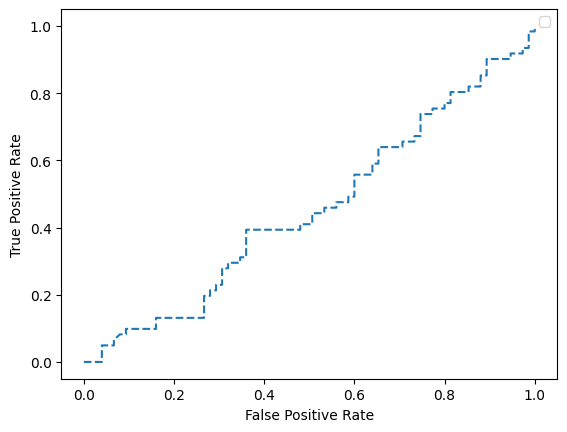

In [16]:
from sklearn.metrics import accuracy_score,roc_curve,confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt_False_Positive_vs_True_Positive
   
    #Confution Matrix    
print('\nConfusion Matrix\n -------------------------')    
print(confusion_matrix(y_true,y_pred_binary));
   
    # accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true, y_pred_binary)
print('Accuracy: %f' % accuracy)
    
    
    # precision tp / (tp + fp)
precision = precision_score(y_true, y_pred_binary)
print('Precision: %f' % precision)
    
    # recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred_binary)
print('Recall: %f' % recall)
    
    # f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, y_pred_binary)
print('F1 score: %f' % f1)    
       
    # ROC AUC
auc = roc_auc_score(y_true, y_pred_prob)
print('ROC AUC: %f' % auc)
    
    
    # calculate roc curves
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        
    # plot the roc curve for the model
plt.figure()
plt_False_Positive_vs_True_Positive.plot(fpr, tpr, linestyle='--', label='')
    
    # axis labels
plt_False_Positive_vs_True_Positive.xlabel('False Positive Rate')
plt_False_Positive_vs_True_Positive.ylabel('True Positive Rate')
       
    # show the legend
plt_False_Positive_vs_True_Positive.legend()
    # show the plot
plt_False_Positive_vs_True_Positive.show()

In [17]:
model.save("project_3d_final.h5")
#model.save('project_3d_final.keras')

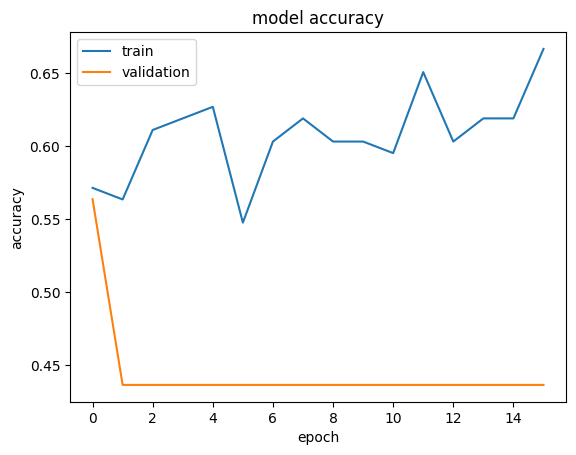

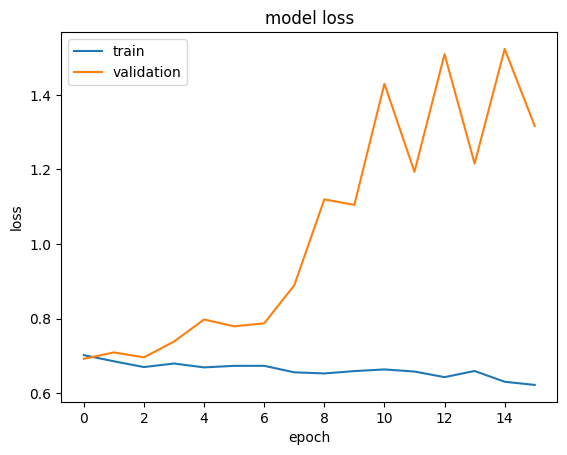

In [18]:
#  "Accuracy"
plt.plot(cnn3d_hist.history['acc'])
plt.plot(cnn3d_hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
    
# "Loss"
plt.plot(cnn3d_hist.history['loss'])
plt.plot(cnn3d_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show();

In [19]:
model = get_model()
#model = get_model(width=128, height=128, depth=64)
model.load_weights('project_3d_trainModel.h5')

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
    run_eagerly=True,
)




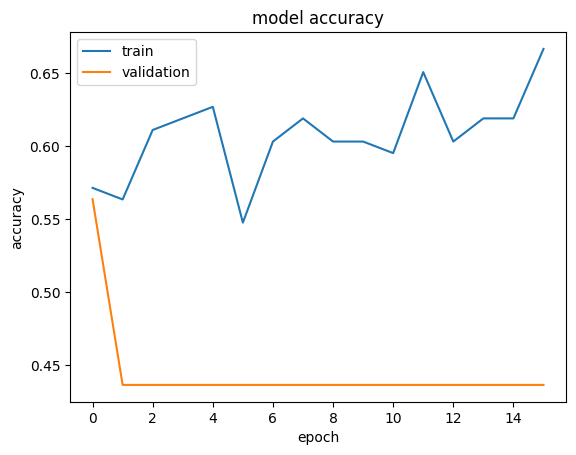

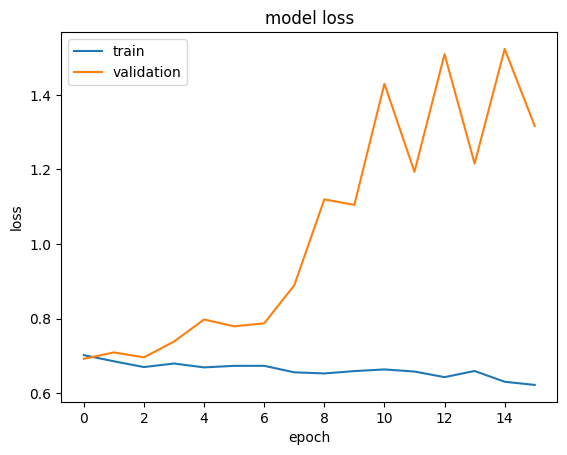

In [20]:
plt.plot(cnn3d_hist.history['acc'])
plt.plot(cnn3d_hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
    
# "Loss"
plt.plot(cnn3d_hist.history['loss'])
plt.plot(cnn3d_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show();

In [21]:
model = get_model()
#model = get_model(width=128, height=128, depth=64)
model.load_weights('project_3d_testModel.h5')

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
    run_eagerly=True,
)

loss, acc = model.evaluate(x_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

2024-07-07 13:39:09.572390: W tensorflow/core/kernels/gpu_utils.cc:68] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


5/5 - 15s - 3s/step - acc: 0.5515 - loss: 1.0622
Restored model, accuracy: 55.15%
